First install the required python dependencies

In [1]:
!pip install -q geopandas pandas

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import math
import time

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


Read taxi pickup data from a csv as a data frame using Pandas

In [3]:
taxi_pts = pd.read_csv("Data/taxi_lab_100k.csv")
taxi_pts.head()
#taxi_pts.size # number of tuples times number of columns in data frame
#taxi_pts.count() #Count non-NA cells for each column or row.
#taxi_pts.shape[0] # number of rows

,lon,lat
0,-73.994770,40.736828
1,-73.982392,40.773382
2,-73.988570,40.739406
3,-73.960213,40.770464
4,-73.995371,40.717248


Read the NYC neighbourhood polygons as a data frame using Geo Pandas For details see https://en.wikipedia.org/wiki/Shapefile The shapefile format is a digital vector storage format for storing geographic location and associated attribute information. It stores the geometry of a given feature as a set of vector coordinates.

In [4]:
nbdata = gpd.read_file("Data/neighborhoods.shp")
nbdata.head()



,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228074,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
1,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904811,"POLYGON ((-73.80379 40.77561, -73.80099 40.775..."
2,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711538,"POLYGON ((-73.86110 40.76366, -73.85993 40.762..."
3,4.0,Queens,081,QN07,Hollis,2.288777e+07,20976.335837,"POLYGON ((-73.75726 40.71814, -73.75589 40.716..."
4,1.0,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.686548,"POLYGON ((-73.94608 40.82126, -73.94640 40.820..."


Borough Park


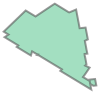

In [5]:
print(nbdata.iloc[0].ntaname)
nbdata.iloc[0].geometry


In [6]:
# what a polygon looks like
with pd.option_context("display.max_colwidth", None):
    print(nbdata['geometry'].head(1))


0    POLYGON ((-73.97605 40.63128, -73.97717 40.63075, -73.97700 40.62987, -73.97685 40.62909, -73.97670 40.62835, -73.97658 40.62757, -73.97651 40.62729, -73.97645 40.62701, -73.97623 40.62598, -73.97726 40.62585, -73.97720 40.62510, -73.97711 40.62495, -73.97694 40.62405, -73.97683 40.62348, -73.97675 40.62301, -73.97657 40.62199, -73.97695 40.62163, -73.97705 40.62153, -73.97539 40.62077, -73.97682 40.61868, -73.97752 40.61768, -73.97785 40.61729, -73.97563 40.61595, -73.97537 40.61575, -73.97544 40.61611, -73.97548 40.61631, -73.97444 40.61642, -73.97336 40.61654, -73.97290 40.61415, -73.97399 40.61403, -73.97517 40.61472, -73.97497 40.61367, -73.97489 40.61319, -73.97478 40.61264, -73.97521 40.61289, -73.97741 40.61422, -73.97964 40.61556, -73.98004 40.61581, -73.98088 40.61631, -73.98187 40.61691, -73.98407 40.61824, -73.98628 40.61957, -73.98569 40.62013, -73.98785 40.62144, -73.99009 40.62279, -73.99255 40.62427, -73.99398 40.62514, -73.99432 40.62534, -73.99489 40.62546, -73.9

https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/

A coordinate reference system (CRS) refers to the way in which spatial data that represent the earth’s surface (which is round / 3 dimensional) are flattened so that you can “Draw” them on a 2-dimensional surface. However each using a different (sometimes) mathematical approach to performing the flattening resulting in different coordinate system grids (discussed below). These approaches to flattening the data are specifically designed to optimize the accuracy of the data in terms of length and area (more on that later too).

Notice in the figure below the differences in shape and orientation associated with each CRS. These differences are a direct result of the calculations used to "flatten" the data onto a two dimensional map. 

![compare-mercator-utm-wgs-projections.jpg](attachment:compare-mercator-utm-wgs-projections.jpg)

In [7]:
# coordinate reference system used
# see https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/

nbdata.crs


<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'NYC WGS84 (lat/lon)')

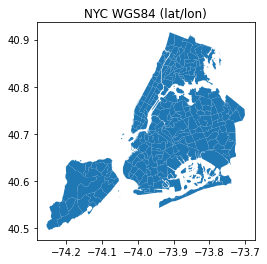

In [8]:
plotnyc = nbdata.plot()
plotnyc.set_title("NYC WGS84 (lat/lon)")


Text(0.5, 1.0, 'NYC Mercator')

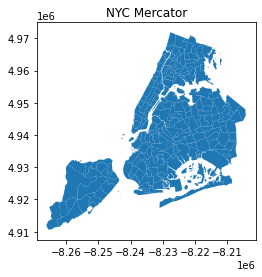

In [9]:
# note the differences in the coordinate systems

nbdata_mercator = nbdata.to_crs("EPSG:3395")
plotnyc_mercator = nbdata_mercator.plot()
plotnyc_mercator.set_title("NYC Mercator")

Function to perform a brute force search to query for all points that are inside a query polygon.
We use shapely to perform this check. Shapely is a Python package that supports geometric types and operations. For details see: https://shapely.readthedocs.io/en/stable/manual.html


In [10]:
# takes a dataframe pts (list of points) and a polygon queryPoly and returns
# a list of points that lie within the polygon
def bruteForceSearch(pts,queryPoly):
  result = []

  num_points = pts.shape[0]  # number of rows in pts
  for i in range(num_points):
    # create a shapely geometric object for point
    pt = Point(pts['lon'][i],pts['lat'][i]) # The Point constructor takes positional 
                                            # coordinate values or point tuple parameters
    # checks if pt lies within queryPoly using a point-in-polygon test
    if queryPoly.contains(pt) == True:   
      result.append(i)
  
  return result

Choose a query polygon from the set of neighborhoods

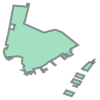

In [11]:
# Query polygon is lower manhattan. 
row = nbdata.loc[(nbdata.ntaname.str.contains('lower manhattan',case=False) == True)]
# extracts polygon from 'geometry' column
lowerMan = row['geometry'].iloc[0] # returns polygon
#lowerMan = row['geometry'] 
lowerMan

Perform a brute-force query and compute the time it takes

In [12]:
start_time = time.time()
result = bruteForceSearch(taxi_pts,lowerMan)
end_time = time.time()
print("time taken: %.4f seconds" %(end_time - start_time))
print("result size:",len(result))

time taken: 4.0536 seconds
result size: 3124


Functions to create a Grid index on a set of 2D points 
![grid](Data/grid-fig.png)
![gridarray](Data/grid-array.png)

In [13]:
# find cell index where value lies in the grid
def getIndex(minval, maxval, res, val):
    ind = math.floor((val - minval) * res / (maxval - minval))
    if ind < 0:
        ind = 0
    if ind >= res:
        ind = res - 1
    return ind

# pts = list of points
# number of xcells, number of ycells (resolution)
# populate grid cells: for each point in pts, identify the cell in
# which it lies


def createGrid(pts,xcells,ycells,xmin,ymin,xmax,ymax):
  grid = [[] for _ in range(xcells * ycells)]
    
  # populate grid cells 
  for i in range(len(pts)):
      # complete
      # identify row and column where the point should be placed
      colidx = getIndex(xmin, xmax, xcells, pts['lon'][i])
      rowidx = getIndex(ymin, ymax, ycells, pts['lat'][i])
 
      # the grid is stored in an array -- need to compute the offset for
      # colidx, rowidx starting from 0
      # 1 -> 2 -> 3
      # 4 -> 5 -> ?
      offset = colidx + rowidx * xcells
      # add point to the right grid cell
      grid[offset].append(i) # lat,long
    
  return grid


Create a grid index on the set of taxi pickups

In [14]:
# see https://archive.nyu.edu/handle/2451/34563; nyap_metadata.pdf
# West -74.260380 East -73.699206
# North 40.917691 South 40.485808
# You can also compute the bounds from the data
#bounds = (-74.277302,40.494835,-73.674025,40.952497) # bounds for the NYC polygon

bounds = nbdata.total_bounds
# array([-74.25559136,  40.4961154 , -73.70000906,  40.91553278])

# A negative latitude means South of the Equator, 
# and a negative longitude means West of the Prime Meridian.


xcells = 1024
ycells = 1024
xmin = bounds[0]
ymin = bounds[1]
xmax = bounds[2]
ymax = bounds[3]

start_time = time.time()
grid = createGrid(taxi_pts, xcells, ycells, xmin, ymin, xmax, ymax)
print("Duration (createGrid): %.4f seconds" %(time.time() - start_time))

Duration (createGrid): 2.3532 seconds


Function to query for points within a query polygon using the Grid Index
![gridarray](Data/grid-search.png)

In [15]:
def gridSearch(pts, grid, queryPoly, xsize, ysize, xmin, ymin, xmax, ymax):
    # compute the coordinates of the query polygon on the grid
    boundxmin = getIndex(xmin, xmax, xsize,queryPoly.bounds[0])
    boundxmax = getIndex(xmin, xmax, xsize,queryPoly.bounds[2])
    boundymin = getIndex(ymin, ymax, ysize,queryPoly.bounds[1])
    boundymax = getIndex(ymin, ymax, ysize,queryPoly.bounds[3])
    
    result = []
    # get the points in each grid cell that intersects with the query polygon,
    # add to result each point that lies inside the polygon
    for x in range(boundxmin, boundxmax):
        for y in range(boundymin, boundymax):
            index = y * xsize + x
            for i in grid[index]:
                pt = Point(pts['lon'][i], pts['lat'][i])
                if queryPoly.contains(pt) == True:
                    result.append(i)
    return result

Perform the same query as above, but using the grid index

In [16]:
start_time = time.time()
# (pts, queryPoly, xsize, ysize, xmin, ymin, xmax, ymax)
result = gridSearch(taxi_pts, grid, lowerMan, xcells, ycells, xmin, ymin, xmax, ymax)
end_time = time.time()
print("Time taken using grid search: %.4f seconds" %(end_time-start_time))
print(len(result))


Time taken using grid search: 1.3289 seconds
3124


Now, you will do some exploration. Create grid indexes of size n x n, where n = {128,256,512,1024,2048,4096}, on the taxi data

a. Plot the running time of the query over lower_manhattan against the index resolution
b. What can be inferred from the plot?
c. Repeat the steps above for different neighborhoods




# a. plot the running time against index resolution

In [17]:
# get total bounds of lower Manhattan
bound = row.total_bounds
xmin = bound[0]
ymin = bound[1]
xmax = bound[2]
ymax = bound[3]
print(bound)

[-74.01934255  40.69406908 -73.99476934  40.71913146]


In [18]:
# print out the time used for each resolution
resolution = [128,256,512,1024,2048,4096]
total_time_used = []
query_time_used = []
for n in resolution:
    xcells = n
    ycells = n
    start_time = time.time()
    grid = createGrid(taxi_pts, xcells, ycells, xmin, ymin, xmax, ymax)
    query_time = time.time()
    result = gridSearch(taxi_pts, grid, lowerMan, xcells, ycells, xmin, ymin, xmax, ymax)
    end_time = time.time()
    print("Resolution: " + str(n) + " * " + str(n))
    print("Time taken using grid search: %.4f seconds" %(end_time-query_time))
    print("Total time used: %.4f seconds" %(end_time-start_time))
    query_time_used.append(end_time-query_time)
    total_time_used.append(end_time-start_time)
    print(len(result))
    print()

Resolution: 128 * 128
Time taken using grid search: 1.4506 seconds
Total time used: 2.7704 seconds
3124

Resolution: 256 * 256
Time taken using grid search: 1.3532 seconds
Total time used: 2.6426 seconds
3124

Resolution: 512 * 512
Time taken using grid search: 1.5216 seconds
Total time used: 3.0020 seconds
3124

Resolution: 1024 * 1024
Time taken using grid search: 1.9111 seconds
Total time used: 4.1573 seconds
3124

Resolution: 2048 * 2048
Time taken using grid search: 3.1126 seconds
Total time used: 6.6056 seconds
3124

Resolution: 4096 * 4096
Time taken using grid search: 9.7855 seconds
Total time used: 21.0773 seconds
3124



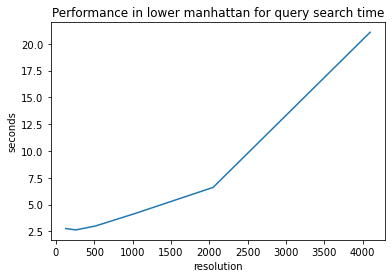

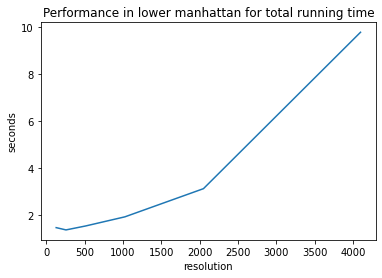

In [21]:
# create a line plot
import matplotlib.pyplot as plt
plt.plot(resolution, total_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in lower manhattan for total running time')

# display the plot
plt.show()

plt.plot(resolution, query_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in lower manhattan for query running time')

# display the plot
plt.show()



# b. what can be inferred 

 The total running time descreased when the resolution changed to 256 * 256 from 128 * 128. 
 However, after 256, the total running time kept increasing with larger resolutions.
 Therefore, there might be a threshold for the resolution such that the closer the resolution
 is to the threshold, the less time is needed for querying with grid.
 The resolution equal to the threshold is the most efficient resolution with respect to the total running time. The query time (only grid search) kept exponentially increasing with larger resolution.

# c. other neighbors

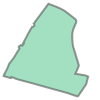

In [23]:
# Query polygon is brooklyn county. 
row = nbdata.loc[(nbdata.ntaname.str.contains('brooklyn',case=False) == True)]
# extracts polygon from 'geometry' column
brooklyn = row['geometry'].iloc[0] # returns polygon
#lowerMan = row['geometry'] 
brooklyn

In [24]:
# get total bounds of kings
bound = row.total_bounds
xmin = bound[0]
ymin = bound[1]
xmax = bound[2]
ymax = bound[3]
print(bound)

[-74.02459594  40.57675118 -73.83355924  40.70908288]


In [25]:
# print out the time used for each resolution
resolution = [128,256,512,1024,2048,4096]
total_time_used = []
query_time_used = []
for n in resolution:
    xcells = n
    ycells = n
    start_time = time.time()
    grid = createGrid(taxi_pts, xcells, ycells, xmin, ymin, xmax, ymax)
    query_time = time.time()
    result = gridSearch(taxi_pts, grid, brooklyn, xcells, ycells, xmin, ymin, xmax, ymax)
    end_time = time.time()
    print("Resolution: " + str(n) + " * " + str(n))
    print("Time taken using grid search: %.4f seconds" %(end_time-query_time))
    print("Total time used: %.4f seconds" %(end_time-start_time))
    query_time_used.append(end_time-query_time)
    total_time_used.append(end_time-start_time)
    print(len(result))
    print()

Resolution: 128 * 128
Time taken using grid search: 0.0102 seconds
Total time used: 1.2628 seconds
155

Resolution: 256 * 256
Time taken using grid search: 0.0118 seconds
Total time used: 1.2363 seconds
155

Resolution: 512 * 512
Time taken using grid search: 0.0127 seconds
Total time used: 1.2919 seconds
159

Resolution: 1024 * 1024
Time taken using grid search: 0.0155 seconds
Total time used: 1.3982 seconds
159

Resolution: 2048 * 2048
Time taken using grid search: 0.0228 seconds
Total time used: 2.3712 seconds
160

Resolution: 4096 * 4096
Time taken using grid search: 0.0450 seconds
Total time used: 9.9875 seconds
160



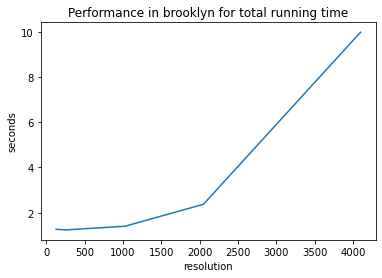

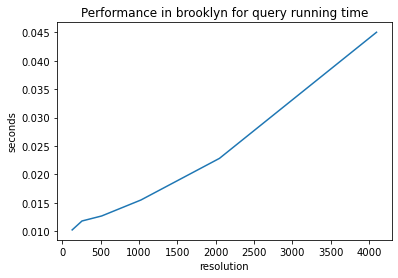

In [28]:
# create a line plot
import matplotlib.pyplot as plt
plt.plot(resolution, total_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in brooklyn for total running time')

# display the plot
plt.show()

plt.plot(resolution, query_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in brooklyn for query running time')

# display the plot
plt.show()

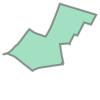

In [29]:
# Query polygon is Chinatown. 
row = nbdata.loc[(nbdata.ntaname.str.contains('Chinatown',case=False) == True)]
# extracts polygon from 'geometry' column
Chinatown = row['geometry'].iloc[0] # returns polygon
#lowerMan = row['geometry'] 
Chinatown

In [30]:
# get total bounds of kings
bound = row.total_bounds
xmin = bound[0]
ymin = bound[1]
xmax = bound[2]
ymax = bound[3]
print(bound)

[-74.00613489  40.70794738 -73.98382387  40.72413645]


In [31]:
# print out the time used for each resolution
resolution = [128,256,512,1024,2048,4096]
total_time_used = []
query_time_used = []
for n in resolution:
    xcells = n
    ycells = n
    start_time = time.time()
    grid = createGrid(taxi_pts, xcells, ycells, xmin, ymin, xmax, ymax)
    query_time = time.time()
    result = gridSearch(taxi_pts, grid, Chinatown, xcells, ycells, xmin, ymin, xmax, ymax)
    end_time = time.time()
    print("Resolution: " + str(n) + " * " + str(n))
    print("Time taken using grid search: %.4f seconds" %(end_time-query_time))
    print("Total time used: %.4f seconds" %(end_time-start_time))
    query_time_used.append(end_time-query_time)
    total_time_used.append(end_time-start_time)
    print(len(result))
    print()

Resolution: 128 * 128
Time taken using grid search: 0.3951 seconds
Total time used: 2.2810 seconds
1774

Resolution: 256 * 256
Time taken using grid search: 0.4217 seconds
Total time used: 1.6646 seconds
1779

Resolution: 512 * 512
Time taken using grid search: 0.4636 seconds
Total time used: 1.7719 seconds
1781

Resolution: 1024 * 1024
Time taken using grid search: 0.7885 seconds
Total time used: 2.2641 seconds
1781

Resolution: 2048 * 2048
Time taken using grid search: 1.8255 seconds
Total time used: 5.8309 seconds
1781

Resolution: 4096 * 4096
Time taken using grid search: 7.2946 seconds
Total time used: 17.8089 seconds
1781



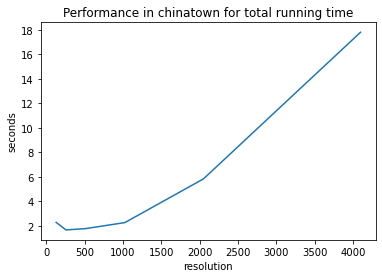

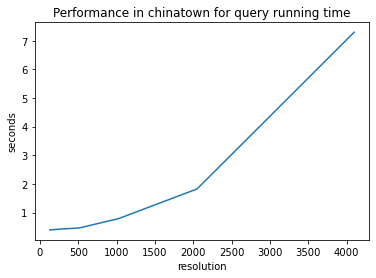

In [32]:
# create a line plot
import matplotlib.pyplot as plt
plt.plot(resolution, total_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in chinatown for total running time')

# display the plot
plt.show()

plt.plot(resolution, query_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in chinatown for query running time')

# display the plot
plt.show()

In [33]:
for i in range(100, 190):
    print(nbdata.ntaname[i])

Windsor Terrace
Prospect Heights
Flatbush
Hunts Point
Canarsie
Flatlands
Sunset Park West
Glen Oaks-Floral Park-New Hyde Park
Douglas Manor-Douglaston-Little Neck
Briarwood-Jamaica Hills
Kew Gardens
Soundview-Castle Hill-Clason Point-Harding Park
Jackson Heights
Park Slope-Gowanus
Charleston-Richmond Valley-Tottenville
Rossville-Woodrow
Cypress Hills-City Line
Central Harlem North-Polo Grounds
East New York
Yorkville
Auburndale
East Flushing
Morrisania-Melrose
Bay Ridge
Melrose South-Mott Haven North
Mott Haven-Port Morris
Belmont
Lower East Side
Claremont-Bathgate
Crotona Park East
Gramercy
Marble Hill-Inwood
East Village
SoHo-TriBeCa-Civic Center-Little Italy
University Heights-Morris Heights
Hudson Yards-Chelsea-Flatiron-Union Square
West Village
Upper West Side
Norwood
Bedford Park-Fordham North
Fordham South
Mount Hope
Eastchester-Edenwald-Baychester
Co-op City
East Tremont
Sheepshead Bay-Gerritsen Beach-Manhattan Beach
Brighton Beach
Breezy Point-Belle Harbor-Rockaway Park-Broad 

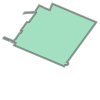

In [34]:
# Query polygon is . 
row = nbdata.loc[(nbdata.ntaname.str.contains('Lincoln Square',case=False) == True)]
# extracts polygon from 'geometry' column
#manhattan = row['geometry'].iloc[0] # returns polygon
LinconSq = row['geometry'].iloc[0]
LinconSq

In [35]:
# get total bounds of kings
bound = row.total_bounds
xmin = bound[0]
ymin = bound[1]
xmax = bound[2]
ymax = bound[3]
print(bound)

[-73.99624065  40.76739215 -73.97500112  40.78177968]


In [36]:
# print out the time used for each resolution
resolution = [128,256,512,1024,2048,4096]
total_time_used = []
query_time_used = []
for n in resolution:
    xcells = n
    ycells = n
    start_time = time.time()
    grid = createGrid(taxi_pts, xcells, ycells, xmin, ymin, xmax, ymax)
    query_time = time.time()
    result = gridSearch(taxi_pts, grid, LinconSq, xcells, ycells, xmin, ymin, xmax, ymax)
    end_time = time.time()
    print("Resolution: " + str(n) + " * " + str(n))
    print("Time taken using grid search: %.4f seconds" %(end_time-query_time))
    print("Total time used: %.4f seconds" %(end_time-start_time))
    query_time_used.append(end_time-query_time)
    total_time_used.append(end_time-start_time)
    print(len(result))
    print()

Resolution: 128 * 128
Time taken using grid search: 1.8250 seconds
Total time used: 3.7169 seconds
3630

Resolution: 256 * 256
Time taken using grid search: 1.8589 seconds
Total time used: 3.1000 seconds
3638

Resolution: 512 * 512
Time taken using grid search: 1.9384 seconds
Total time used: 3.1958 seconds
3640

Resolution: 1024 * 1024
Time taken using grid search: 2.2945 seconds
Total time used: 3.6620 seconds
3640

Resolution: 2048 * 2048
Time taken using grid search: 3.3183 seconds
Total time used: 6.0024 seconds
3640

Resolution: 4096 * 4096
Time taken using grid search: 8.9652 seconds
Total time used: 19.5065 seconds
3640



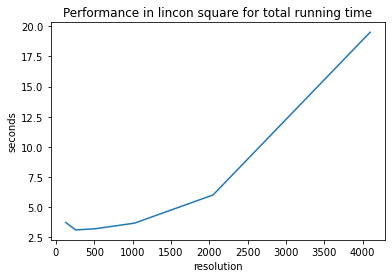

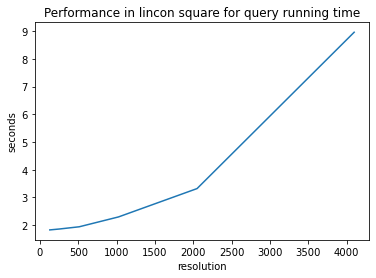

In [37]:
# create a line plot
import matplotlib.pyplot as plt
plt.plot(resolution, total_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in lincon square for total running time')

# display the plot
plt.show()

plt.plot(resolution, query_time_used)
# set the x and y axis labels
plt.xlabel('resolution')
plt.ylabel('seconds')

# set the title of the plot
plt.title('Performance in lincon square for query running time')

# display the plot
plt.show()